In [7]:
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from train import train_model, train_loss, train_accuracy, val_loss, val_accuracy
from torchsummary import summary
import time
import copy
import seaborn as sns
sns.set(font_scale=1.4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32


dataset = torch.load('64noskulldataset.pt')
lengths = [

    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]

trainset, valset, testset = random_split(dataset, lengths)
image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  

In [8]:
class MultiCNN(nn.Module):
    def __init__(self):
        super(MultiCNN, self).__init__()
        self.fc1 = nn.Linear(6144, 256)
        self.fc2 = nn.Linear(256, 2)
        self.fc3 = nn.Linear(10, 2)
        resnet = models.resnet50(pretrained=True).to(device) 
        self.new_resnet1 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet2 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet3 = nn.Sequential(*list(resnet.children())[:-1])
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x_slices):

        x1 = x_slices[0]
        x1 = self.new_resnet1(x1)
        x1 = x1.view(-1, 2048)

        x2 = x_slices[1]
        x2 = self.new_resnet2(x2)
        x2 = x2.view(-1, 2048)

        x3 = x_slices[2]
        x3 = self.new_resnet3(x3)
        x3 = x3.view(-1, 2048)

        out = torch.cat((x1, x2, x3), dim=-1)
        out = F.relu(self.drop(self.fc1(out)))
        out = F.relu(self.fc2(out))

        return out

Epoch 0/24
----------------------------------------------------------------------------------------------------



train Loss: 0.6527 Acc: 0.5975



val Loss: 0.6291 Acc: 0.5932
Epoch 1/24
----------------------------------------------------------------------------------------------------



train Loss: 0.4956 Acc: 0.6028



val Loss: 0.7061 Acc: 0.5932
Epoch 2/24
----------------------------------------------------------------------------------------------------



train Loss: 0.4302 Acc: 0.6049



val Loss: 0.7653 Acc: 0.5932
Epoch 3/24
----------------------------------------------------------------------------------------------------



train Loss: 0.4060 Acc: 0.6123



val Loss: 0.7025 Acc: 0.6017
Epoch 4/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2949 Acc: 0.8549



val Loss: 0.6584 Acc: 0.7627
Epoch 5/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2139 Acc: 0.9110



val Loss: 0.9118 Acc: 0.8220
Epoch 6/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1004 Acc: 0.9619



val Loss: 1.0366 Acc: 0.7119
Epoch 7/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0745 Acc: 0.9714



val Loss: 1.0737 Acc: 0.7542
Epoch 8/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0540 Acc: 0.9799



val Loss: 1.0379 Acc: 0.7797
Epoch 9/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0538 Acc: 0.9799



val Loss: 0.9787 Acc: 0.7881
Epoch 10/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0400 Acc: 0.9883



val Loss: 1.0171 Acc: 0.7797
Epoch 11/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0323 Acc: 0.9926



val Loss: 1.0225 Acc: 0.7712
Epoch 12/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0328 Acc: 0.9915



val Loss: 1.0887 Acc: 0.7542
Epoch 13/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0266 Acc: 0.9915



val Loss: 1.0094 Acc: 0.7712
Epoch 14/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0257 Acc: 0.9947



val Loss: 1.0543 Acc: 0.7797
Epoch 15/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0260 Acc: 0.9905



val Loss: 1.0782 Acc: 0.7542
Epoch 16/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0271 Acc: 0.9936



val Loss: 1.0187 Acc: 0.7712
Epoch 17/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0238 Acc: 0.9947



val Loss: 1.0335 Acc: 0.7712
Epoch 18/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0227 Acc: 0.9958



val Loss: 1.0498 Acc: 0.7712
Epoch 19/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0305 Acc: 0.9905



val Loss: 1.0824 Acc: 0.7627
Epoch 20/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0219 Acc: 0.9936



val Loss: 1.0845 Acc: 0.7627
Epoch 21/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0278 Acc: 0.9905



val Loss: 1.0670 Acc: 0.7797
Epoch 22/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0257 Acc: 0.9936



val Loss: 1.0863 Acc: 0.7881
Epoch 23/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0237 Acc: 0.9915



val Loss: 1.0816 Acc: 0.7712
Epoch 24/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0246 Acc: 0.9894



val Loss: 1.1111 Acc: 0.7712
Training complete in 1m 41s
Best val Acc: 0.822034


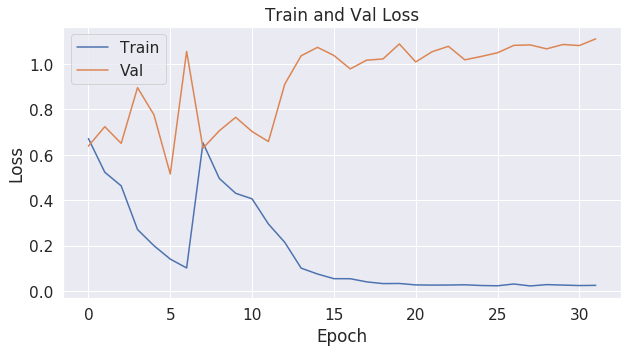

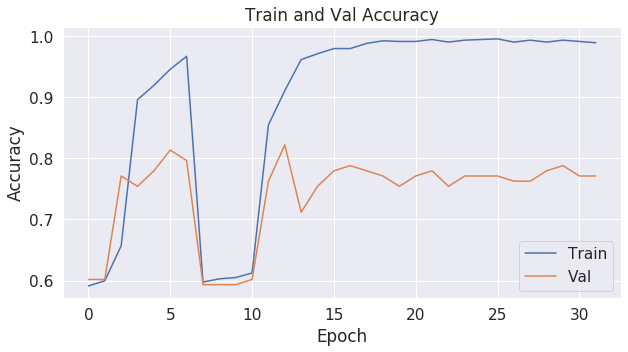

In [9]:
model = MultiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=25, batch_size = batch_size)

In [10]:
running_loss = 0.0
running_corrects = 0
for inputs, labels in tqdm(dataloaders['test'], total = dataset_sizes['test']//32+1):
    labels = labels.to(device)
    inputs = [i.to(device, dtype = torch.float) for i in inputs]

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


    running_loss += loss.item() * 32
    running_corrects += torch.sum(preds == labels.data)
    
print(f"Test Loss: {running_loss / dataset_sizes['test']}\nTest Accuracy: {running_corrects.double() / dataset_sizes['test']}")



Test Loss: 0.7189517061249548
Test Accuracy: 0.7983193277310924


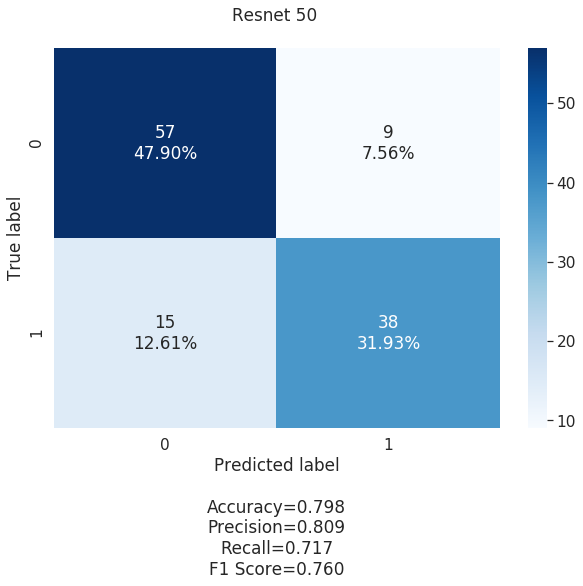

In [11]:
from confusionmatrix import make_confusion_matrix

nb_classes = 2
cf = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        classes = classes.to(device)
        inputs = [i.to(device, dtype=torch.float) for i in inputs]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(classes.view(-1), preds.view(-1)):
            cf[t.long(), p.long()] += 1

cf = np.array(cf)

group_names = ['bruh','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.reshape(-1)/cf.sum()]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

make_confusion_matrix(cf, group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize= (10,7),
                          cmap='Blues',
                          title='Resnet 50 \n')